# Linear Models - splines

### [Polynomial Regression & Basis Functions](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
- Common use case: training linear models on __nonlinear__ data. (This allows for generally fast performance while allowing linear models to work with a wider array of data.)
- Std linear regression model (2D): __$\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2$__
- To fit a paraboloid (instead of a plane) to the model, we could use: $\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1 x_2 + w_4 x_1^2 + w_5 x_2^2$
- So a linear model trained on polynomial features is able to recover polynomial coefficients.

In [95]:
from sklearn.preprocessing import PolynomialFeatures as PF
import numpy as np
X = np.arange(6).reshape(3, 2)
print(X)
poly = PF(degree=2)
poly.fit_transform(X)

[[0 1]
 [2 3]
 [4 5]]


array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

- This work can be done using pipelines too. Below: an object representing a polynomial regression being created.

In [96]:
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.linear_model import LinearRegression as LR
from sklearn.pipeline import Pipeline
import numpy as np

model = Pipeline([('poly',   PF(degree=3)),
                  ('linear', LR(fit_intercept=False))])

# fit to an order-3 polynomial data
x = np.arange(5)
y = 3 - 2 * x + x ** 2 - x ** 3
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_

array([ 3., -2.,  1., -1.])

- Sometimes it's not necessary to include higher powers of any single feature - just the _interaction_ features that multiply together at the _d_ most distinct features. (They can be found using __PolynomialFeatures__ with `interaction_only=True`.)

- For example (boolean features): $x_i x_j$ represents the conjunction of two booleans. We can solve an XOR problem with a linear classifier.

In [97]:
from sklearn.linear_model import Perceptron as P
from sklearn.preprocessing import PolynomialFeatures as PF
import numpy as np

X   = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y   = X[:, 0] ^ X[:, 1]
X   = PF(interaction_only=True).fit_transform(X).astype(int)
clf = P(fit_intercept=False, 
        max_iter=10, tol=None, shuffle=False).fit(X, y)

print('prediction:\t',clf.predict(X),'\n', 
      'score:\t\t',clf.score(X,y))

prediction:	 [0 1 1 0] 
 score:		 1.0


### [example - approximate n-degree polynomial with ridge regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)
- Two methods, given `n_samples` of 1d points `x_i`.
- [polynomial transformers](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures): generates all monomials up to `degree`. This gives a __vandermonde matrix__.
- [spline transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html#sklearn.preprocessing.SplineTransformer): generates B-spline basis functions (piece-wise polynomial functions).

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge as R
from sklearn.pipeline import make_pipeline as MP
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import SplineTransformer as ST

In [99]:
# function to be approximated
def f(x):
    return x*np.sin(x)

# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

In [100]:
# training data subset
x_train = np.linspace(0, 10, 100)
rng     = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot  = x_plot[:, np.newaxis]

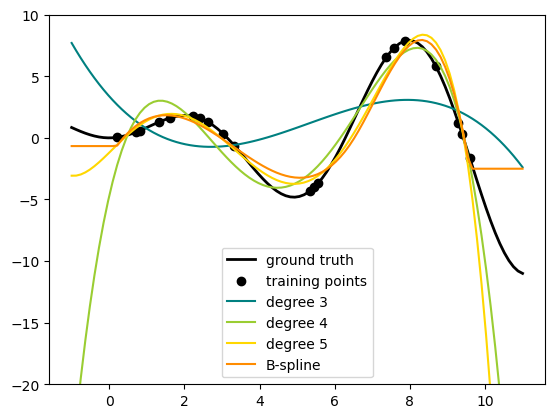

In [101]:
# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = MP(PF(degree), R(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = MP(ST(n_knots=4, degree=3), R(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()


- Results:
  - higher degree polynomials = better fit
  - "too high" degree polynomials = oscillations
  - B-splines: "as good as" fit, smoother behavior, extrapolation controls
- Below: plot all columns of both transformers for more insight.

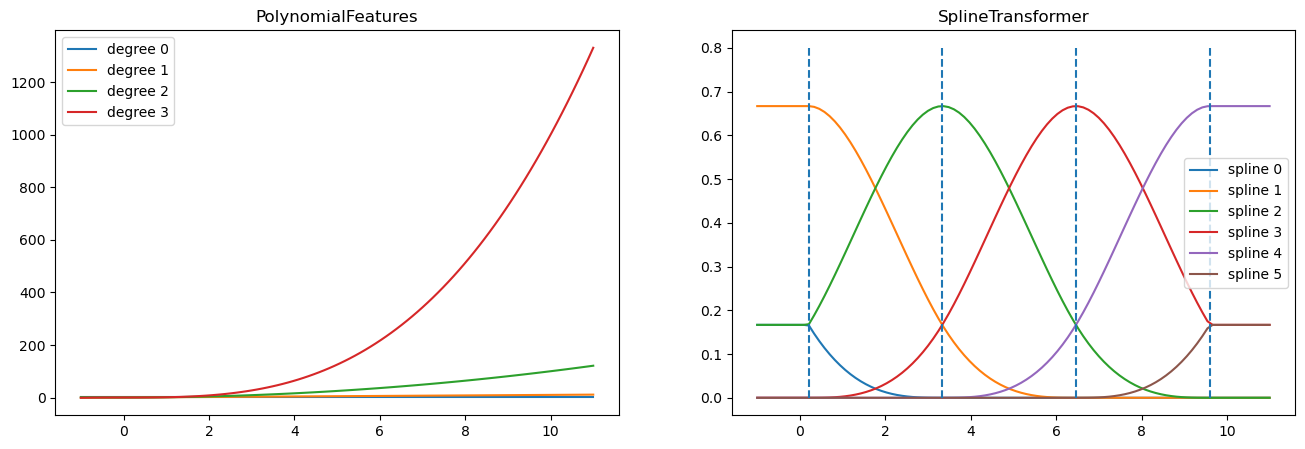

In [102]:
pft  = PF(degree=3).fit(X_train)
splt = ST(n_knots=4, degree=3).fit(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

axes[0].plot(x_plot, pft.transform(X_plot))
axes[1].plot(x_plot, splt.transform(X_plot))

axes[0].legend(axes[0].lines, [f"degree {n}" for n in range(4)])
axes[1].legend(axes[1].lines, [f"spline {n}" for n in range(6)])

axes[0].set_title("PolynomialFeatures")
axes[1].set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
axes[1].vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

- __left__: lines corresponding to monomials from `x^0` to `x^3`.
- __right__: six b-spline basis functions with `degree=3`, plus the four chosen __knot__ positions chosen during `fit`.
    - note there are `degree` additional knots to the left & right of the fitted interval (hidden from view).

### Periodic splines
- Previous example we saw the limitations of polynomials and splines for extrapolation beyond the range of the training observations.
- We often expect periodic components of the underlying signal. They  can be modelled using __periodic splines__ which have equal function value & equal derivatives at the first & last knot.
- Below: demonstrate how periodic splines provide a better fit within and outside the training data range, given the additional periodicity information. The splines period is the distance between the first and last knot, which we specify manually.
- Periodic splines can be useful for naturally periodic features (such as day of the year) - the smoothness at the boundary knots prevents a jump in the transformed values (e.g. from Dec 31st to Jan 1st).
- For periodic features, consider explicitly passing this information to the __SplineTransformer__ by setting the knots manually.

/tmp/ipykernel_102104/1440003159.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


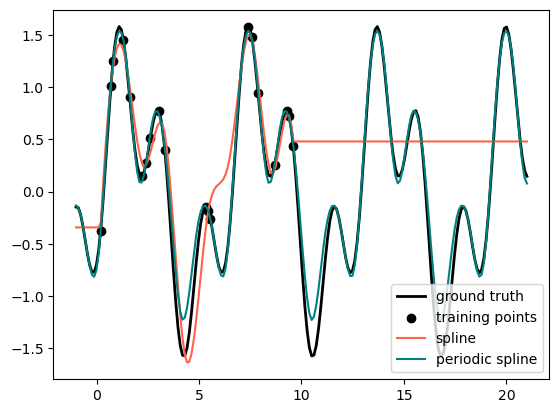

In [103]:
# Function to be approximated by periodic spline interpolation
def g(x):
    return np.sin(x) - 0.7 * np.cos(x * 3)
y_train = g(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (ST(degree=3, n_knots=10), "spline"),
    (
        ST(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = MP(transformer, R(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

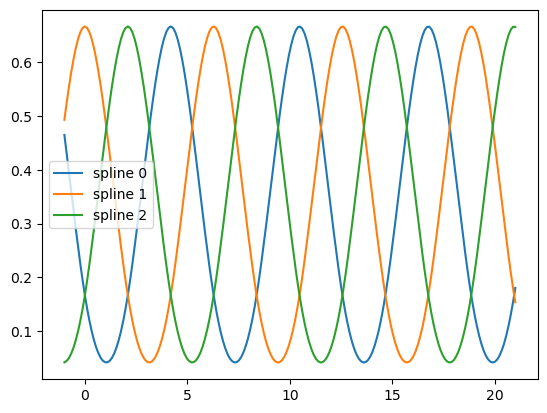

In [104]:
fig, ax = plt.subplots()
knots = np.linspace(0, 2 * np.pi, 4)
splt = ST(knots=knots[:, None], degree=3, extrapolation="periodic").fit(
    X_train
)
ax.plot(x_plot_ext, splt.transform(X_plot_ext))
ax.legend(ax.lines, [f"spline {n}" for n in range(3)])
plt.show()